## Linear Regression
Implementing linear regression, this will be generlized for both univariate and multivariate.

key skills to learn 
 - Univarite
 - Multivarite
 - Feature scaling
 - hypothesis or model prediction
 - weights initialization
 - Gradient computation
 - Cost function 
 - Gradient descent update
 - plot cost 
 
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import random
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Diabetes dataset 
This dataset is already preprocessed and divided into features and labels, we will use it to
train linear regression models such multivarite and univariate.

In [2]:
# get linear regression dataset from sklearn
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)


X_train = diabetes_X
Y_train = diabetes_y.reshape(1, -1).T

## Define Regression model
- option to define any hypothesis such uni and multivarite
- weights initialization
- feature scaling if not performed already 


In [29]:
class Model:
    """define a model type such as linear regression with multiple variables and polynomial regression etc.
    
    Parameters
    ---------
    X: np.ndarray
       input features, already normalized. Shape: (m, nx)
    y: np.ndarray
       ground truth labels for each example. Shape: (m, 1), where 2 for begnin and 4 for malignant
    epsilon: float
       a value to use to randomly initialize weights and scale them
    model_name: str
       type of the regression model such as linear regression, polynomail regression, or any other type
    
        
    """
    def __init__(self, X, y, epsilon = 100, model_name = "linear_regression"):
        self.X_orig = X
        self.X = np.insert(X, 0, 1, axis = 1)
        self.y = y
        self.m = X.shape[0]
        self.epsilon = epsilon
        
    def initailize_params(self, shape = None):
        if shape is None:
            theta = np.random.randn(self.X.shape[1], 1) * self.epsilon
        else:
            theta = np.random.randn(shape[0], shape[1]) * self.epsilon
        return theta
        
    
    def linear_regression(self, params):
        return self.X @ params
    
    def polynomial_regression(self, kind = "quadratic"):
        
        if kind == "3rd order" and self.X_orig.shape[1] == 1:
            X = np.c_[np.ones(self.m), self.X_orig, np.square(self.X_orig), np.power(self.X_orig, 3)]
            m, features = X.shape
            params = self.initailize_params((features, 1))
            hypothesis = X @ params
        elif kind == "quadratic" and self.X_orig.shape[1] == 1:
            X = np.c_[np.ones(self.m), self.X_orig, np.square(self.X_orig)]
            m, features = X.shape
            params = self.initailize_params((features, 1))
            hypothesis = X @ params
        elif kind == "higer order" and self.X_orig.shape[1] == 1:
            X = np.c_[np.ones(self.m),  np.square(self.X_orig), np.power(self.X_orig, 3), np.power(self.X_orig, 4), 
                     np.power(self.X_orig, 5), np.power(self.X_orig, 6), np.power(self.X_orig, 7), np.power(self.X_orig, 8),
                     np.power(self.X_orig, 9), np.power(self.X_orig, 10)]
            m, features = X.shape
            params = self.initailize_params((features, 1))
            hypothesis = X @ params
        return hypothesis
    
    def normalize(self, X):
        """normalize features to have 0 mean and 1 std deviation

        Args:
            X: np.ndarray 

        Return:
            X_normalize: np.ndarray"""
        mean = np.mean(X, axis = 0)
        std = np.std(X, axis = 0)
        X_normalized = (X - mean)/std
        return X_normalized
    
    
        
        
model = Model(X_train, Y_train)
params = model.initailize_params()
linear_regression = model.linear_regression(params)
assert linear_regression.shape == Y_train.shape, "Error: Model prediction dimension and ground truth dimesion doesn't match"


## Cost Function
least square cost function that takes predictions and ground truth labels to measure how close 
they are to each other. The cost will be minimal if they are closed, and maximum when they are opposite of each other.


In [4]:
def compute_cost(Y, predictions):
    """compute the cost for the model prediction on the dataset
    
    Parameters
    ----------
    Y: np.ndarray
       Ground truth labels for the features in the dataset
    predictions: np.ndarray
       Model prediction on the training set
    """
    # number of training examples in the dataset
    Y = Y.reshape(1, -1).T
    predictions = predictions.reshape(1, -1).T
    m = Y.shape[0]
    cost = (1/(2*m)) * np.transpose((predictions - Y))@(predictions - Y)
    cost = np.squeeze(cost)
    return cost

In [5]:
#Test cases cost funtion
predictions = np.array([[1, 1, 1, 0]], dtype = np.float32)
labels = np.array([[1, 0, 1, 0]], dtype = np.float32)
print(f"Cost: " + str(compute_cost(labels, predictions)))

Cost: 0.125


## Calculate Derivate of cost with respect to parameters
compute_gradients function calculates derivates of cost with respect to each of the parameters.
The size of graidents should be same as paramters

In [6]:
def compute_gradients(X, Y, params):
    """calculate gradients of the cost with respect params
    
    Parameters
    ----------
    X: np.ndarray
       features 
    Y: np.ndarray
       labels
    params: np.ndarray
       model paramters
    model: Model
       linear regression hypothesis
    """

    m = X.shape[0]
    X = np.insert(X, 0, 1, axis = 1)
    Y = Y.reshape(1, -1).T
    dev = (1/m) * np.transpose(X) @ (X @ params - Y) 

    return dev

In [7]:
#check gradients
gradients = compute_gradients(X_train, Y_train, params)
assert gradients.shape == params.shape, "Error, shape doesnt match"

## Apply Gradient Descent update 
apply gradient descent algorithm to update the parameters using gradient you calculated in the previous step.

In [8]:
def gradient_descent(gradients, params, learning_rate = 1e-2):
    '''gradient descent update
    
    Parameters
    ----------
    gradients: np.ndarray
               derivatives of the cost w.r.t to params
    params: np.ndarray
               model params
    learning_rate: float
               learning rate for update
    '''
    assert params.shape == gradients.shape, f'Error, parameters and gradients should have the same dimensions, params: {params.shape} != {gradients.shape}'
    params = params - learning_rate * gradients
    return params

## Train the model
Now that every helper function is written, it's time to train the ML model. This will work as follows:
repeat until convergence
1. initialize weights ( at the first iteration only)
2. calculate predictions
3. measure cost between predictions and ground truth
4. calculate gradients/derivatives of cost w.r.t to model learnable parameters
5. update parameters using gradient descent algorithm

if converges return parameters 

In [34]:
def train(X, y, model, params, learning_rate = 1e-3, num_iter = 20000, print_cost = True, regression = None):
    """train the machine learning model now
    
    Parameters
    ----------
    X: np.ndarray
       input features
    y: np.ndarray
       labels
    params: np.ndarray
       initial weights
    learning_rate: float
       learning rate value for gd update
    num_iter: int
       number of interations to train the model for
    """
    costs = []
    iters = []
    for i in range(num_iter):
        if regression is None:
            predictions = model.linear_regression(params)
        else:
            predictions = model.polynomial_regression(regression)
        cost = compute_cost(y, predictions)
        gradients = compute_gradients(X, y, params)
        params = gradient_descent(gradients, params, learning_rate)
        
        if i % 1000 == 0 and print_cost:
            costs.append(cost)
            iters.append(i)
            print(f"iteration: {i}, cost: {cost}")
    plt.plot(iters, costs, "b-")
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.title("learning curve")
    return params

## Divide the dataset into test and train

In [11]:
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]


In [12]:
print(f'training features: {diabetes_X_train.shape}, and training labels: {diabetes_y_train.shape}')
print(f'testing features: {diabetes_X_test.shape}, and training labels: {diabetes_y_test.shape}')


training features: (422, 1), and training labels: (422,)
testing features: (20, 1), and training labels: (20,)


(Text(0.5, 0, 'features'), Text(0, 0.5, 'label'))

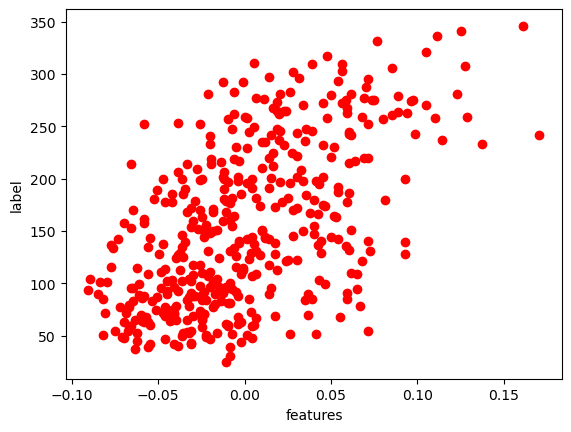

In [26]:
plt.plot(diabetes_X_train, diabetes_y_train, "or")
plt.xlabel("features"), plt.ylabel("label")

iteration: 0, cost: 18984.92041681344
iteration: 1000, cost: 5599.861092026065
iteration: 2000, cost: 3784.224372145456
iteration: 3000, cost: 3532.7990407245034
iteration: 4000, cost: 3492.881772635608
iteration: 5000, cost: 3481.587139763663
iteration: 6000, cost: 3474.1889359748093
iteration: 7000, cost: 3467.344061099244
iteration: 8000, cost: 3460.600408545262
iteration: 9000, cost: 3453.896734203683
iteration: 10000, cost: 3447.224639059486
iteration: 11000, cost: 3440.582869284184
iteration: 12000, cost: 3433.971137612076
iteration: 13000, cost: 3427.389287988727
iteration: 14000, cost: 3420.837182629156
iteration: 15000, cost: 3414.3146867457262
iteration: 16000, cost: 3407.821666480971
iteration: 17000, cost: 3401.3579886257367
iteration: 18000, cost: 3394.9235205787268
iteration: 19000, cost: 3388.5181303386707


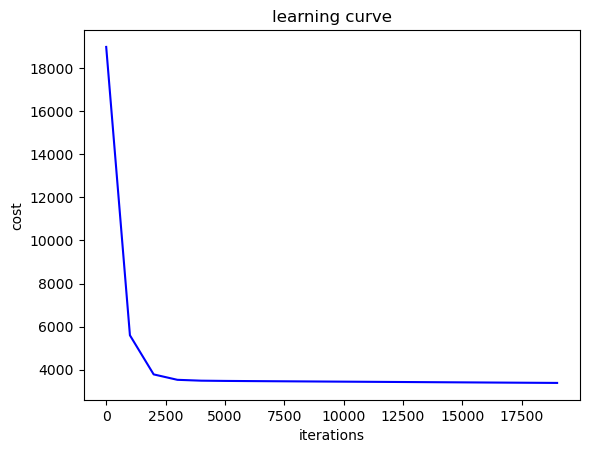

In [35]:
# Now train...
model = Model(diabetes_X_train, diabetes_y_train)
params = model.initailize_params()
# print(params.shape)
params = train(diabetes_X_train, diabetes_y_train, model, params, regression = None)

## SKlearn implementation


Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


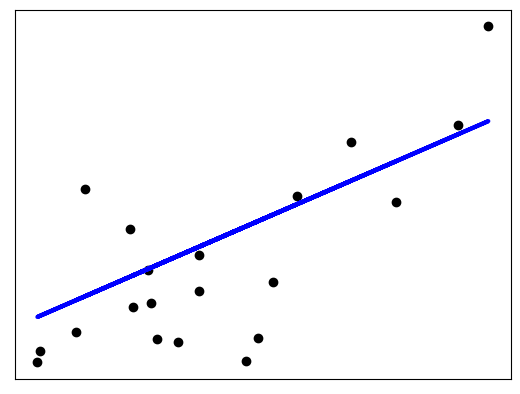

In [16]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()